# Regression of Used Car Prices

## Import library and read data

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import mutual_info_classif

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from scipy.stats import loguniform, uniform

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data_dir = '/kaggle/input/playground-series-s4e9/'
raw_df = pd.read_csv(data_dir + 'train.csv')
test_df = pd.read_csv(data_dir + 'test.csv')
sub_df = pd.read_csv(data_dir + 'sample_submission.csv')

original_data_dir = '/kaggle/input/used-car-price-prediction-dataset/'
original_df = pd.read_csv(original_data_dir + 'used_cars.csv')

In [3]:
raw_df.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [4]:
raw_df.isna().sum()

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

In [5]:
def draw_numeric_features(data, x=None, y=None, overlap=None):
    plt.figure(figsize=(30,10))
    plt.grid()
    sns.lineplot(data, x=x, y=y)
    if overlap is not None:
        for plot in overlap:
            sns.lineplot(data=plot[0], x=plot[1], y=plot[2])

def view_avg_of_each(cat_features: str, target: str):
    d = dict()
    cols = raw_df[cat_features].unique()
    for x in cols:
        d[x] = raw_df[raw_df[cat_features]==x][target].mean()
    return pd.Series(d, index=cols)

In [6]:
raw_df['price'].describe()

count    1.885330e+05
mean     4.387802e+04
std      7.881952e+04
min      2.000000e+03
25%      1.700000e+04
50%      3.082500e+04
75%      4.990000e+04
max      2.954083e+06
Name: price, dtype: float64

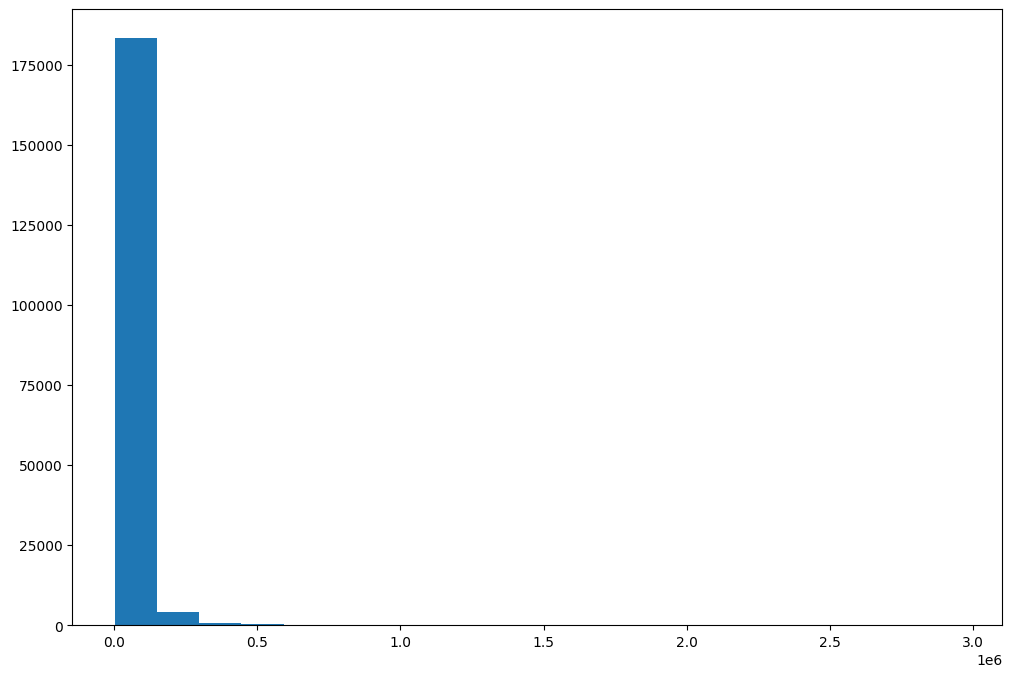

In [7]:
plt.figure(figsize=(12,8))
plt.hist(raw_df['price'], bins=20);

In [8]:
numeric_features = []
categorical_features = []
original_features = raw_df.columns.tolist()

## EDA & Feature Engineering

In [9]:
# Threshold to classify which values is noise
min_threshold = 100

### Brand

In [10]:
len(raw_df['brand'].unique())

57

In [11]:
categorical_features.append('brand')

### Model

In [12]:
len(raw_df['model'].unique())

1897

In [13]:
noise_model = raw_df['model'].value_counts(dropna=False)
noise_model = noise_model[noise_model<min_threshold]
len(noise_model)

1417

In [14]:
for df in [raw_df, test_df, original_df]:
    df['short_model'] = df['model'].apply(lambda x: str(x).split(' ')[0])
    df['model'] = df['model'].apply(lambda x: 'noise' if x in noise_model else x)

In [15]:
len(raw_df['short_model'].unique())

517

In [16]:
categorical_features += ['model', 'short_model']

### Model year

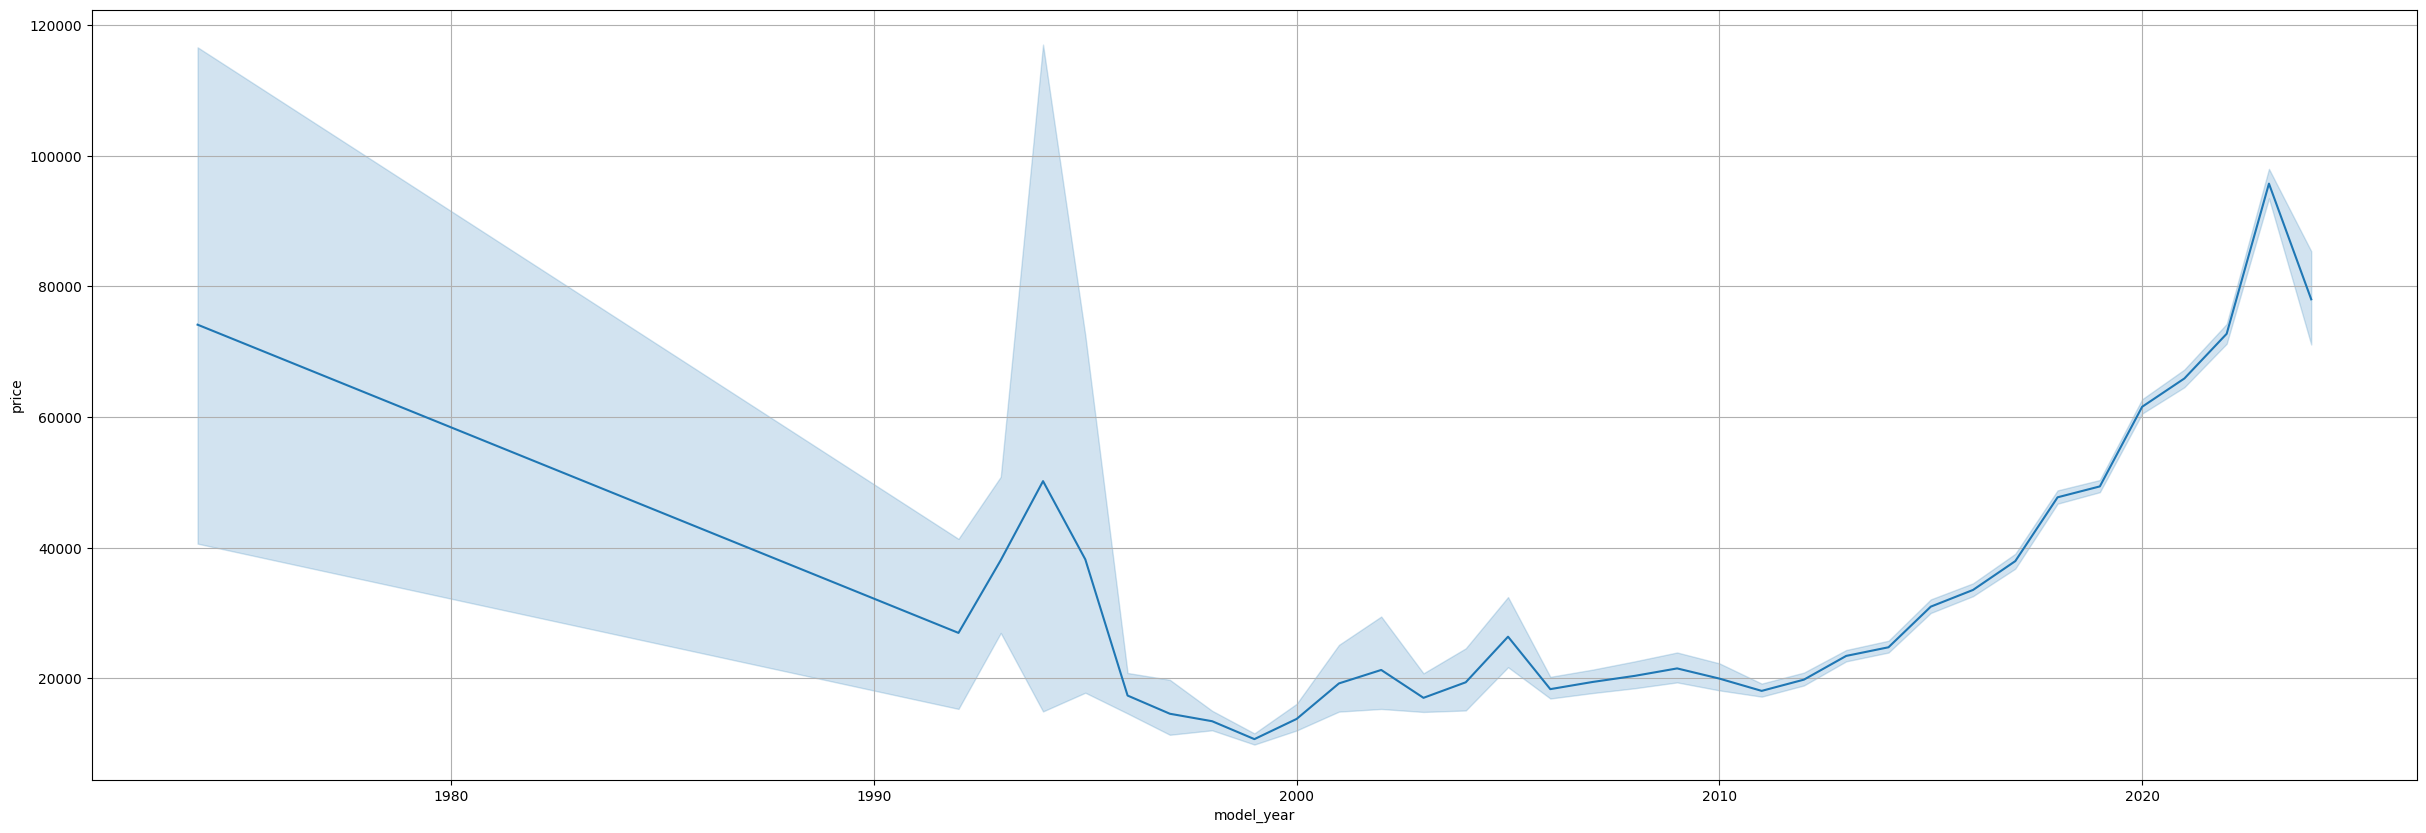

In [17]:
draw_numeric_features(data=raw_df, x='model_year', y='price')

In [18]:
def get_year_group(x):
    if x<=1986:
        return 0
    if x<=1995:
        return 1
    if x<=2004:
        return 2
    if x<=2012:
        return 3
    if x<=2019:
        return 4
    if x<=2022:
        return 5
    return 6

def get_assessing_epreciation_percent(x):
    if x<=3:
        return 6.5 * x
    if x<=7:
        return 6 * (x - 3) + 6.5 * 3
    if x<=10:
        return 8.5 * (x-7) + 6 * 4 + 6.5 * 3
    return 8.5 * 3 + 6 * 4 + 6.5 * 3 + 0.15 * (x-10)

In [19]:
for df in [raw_df, test_df, original_df]:
    df['model_year_group'] = df['model_year'].apply(lambda x: get_year_group(x))
    df['model_year'] = df['model_year'].apply(lambda x: 2024-x)
    df['assessing_epreciation_percent'] = df['model_year'].apply(lambda x: get_assessing_epreciation_percent(x))

In [20]:
view_avg_of_each('model_year_group','price')

3    20153.641926
2    17859.240809
4    37791.474344
5    66676.368290
6    95386.817378
1    40873.508621
0    74124.083333
dtype: float64

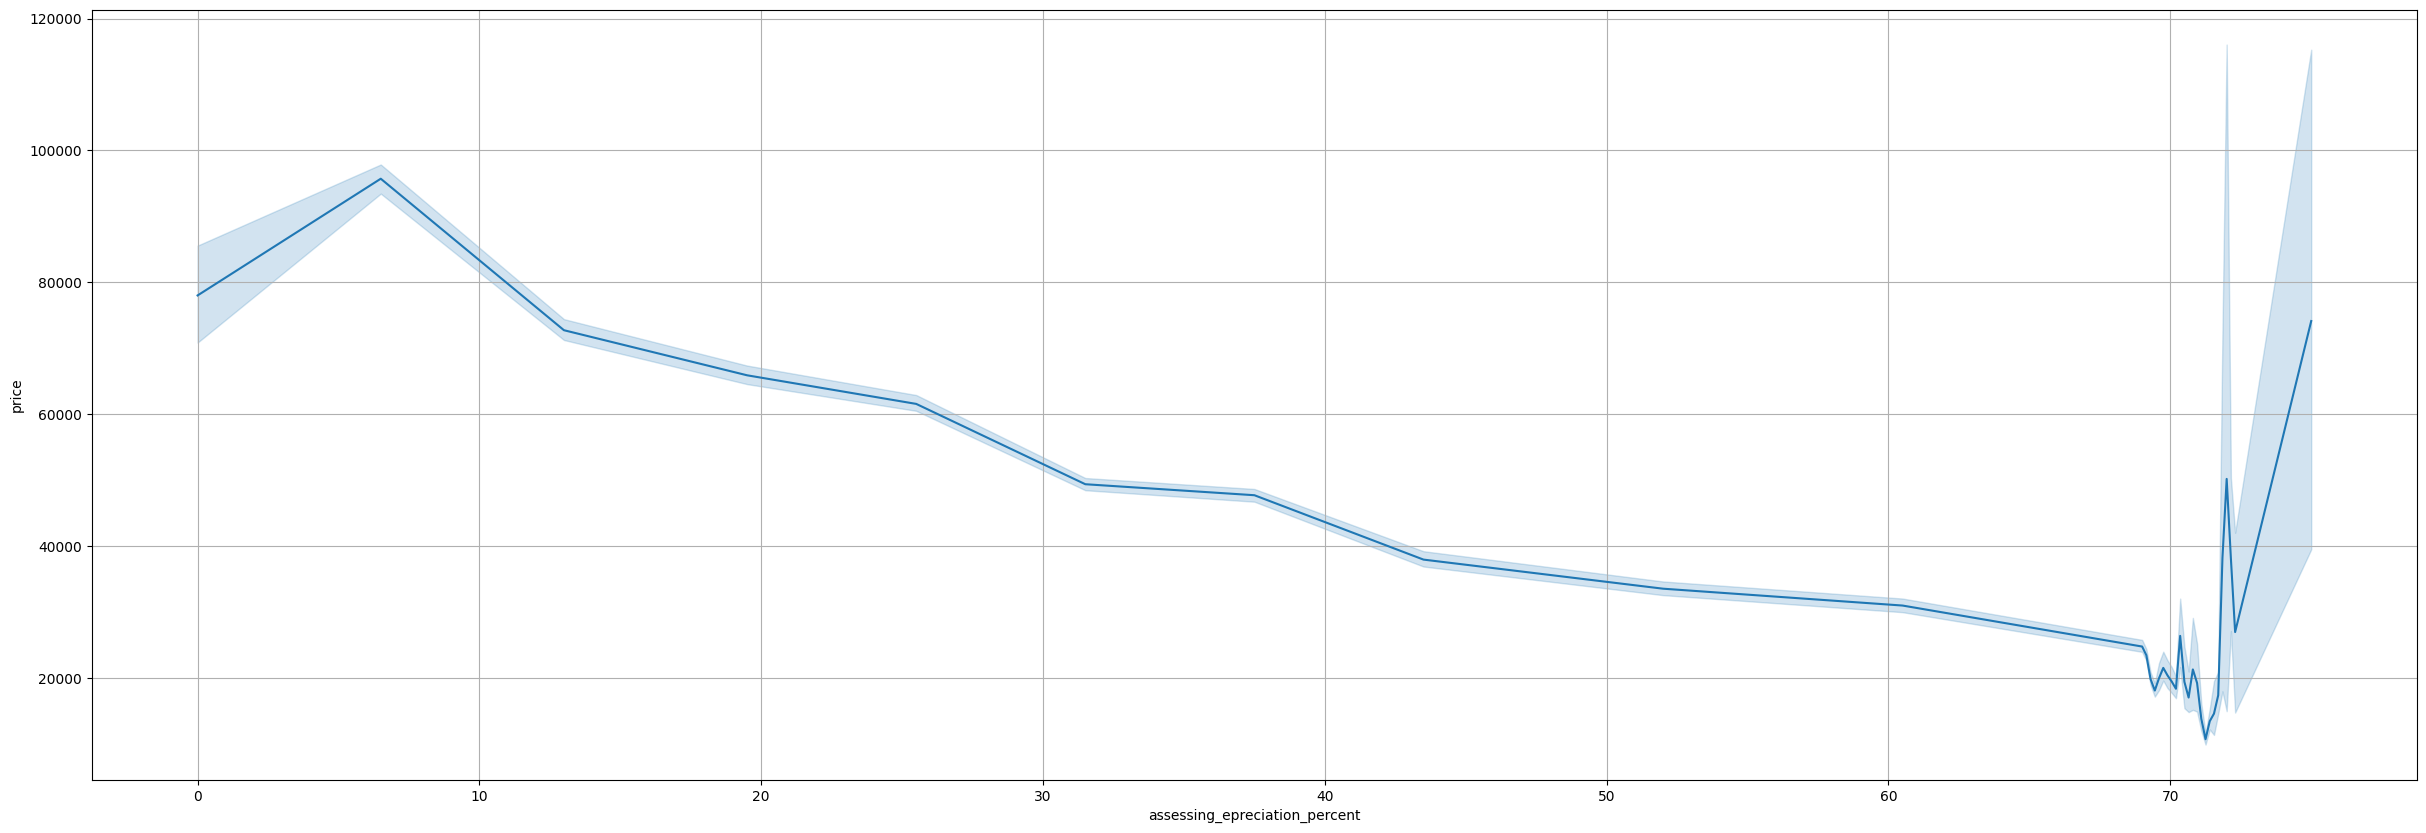

In [21]:
draw_numeric_features(data=raw_df, x='assessing_epreciation_percent', y='price')

In [22]:
numeric_features += ['model_year','model_year_group',
                     'assessing_epreciation_percent']

### Mileage

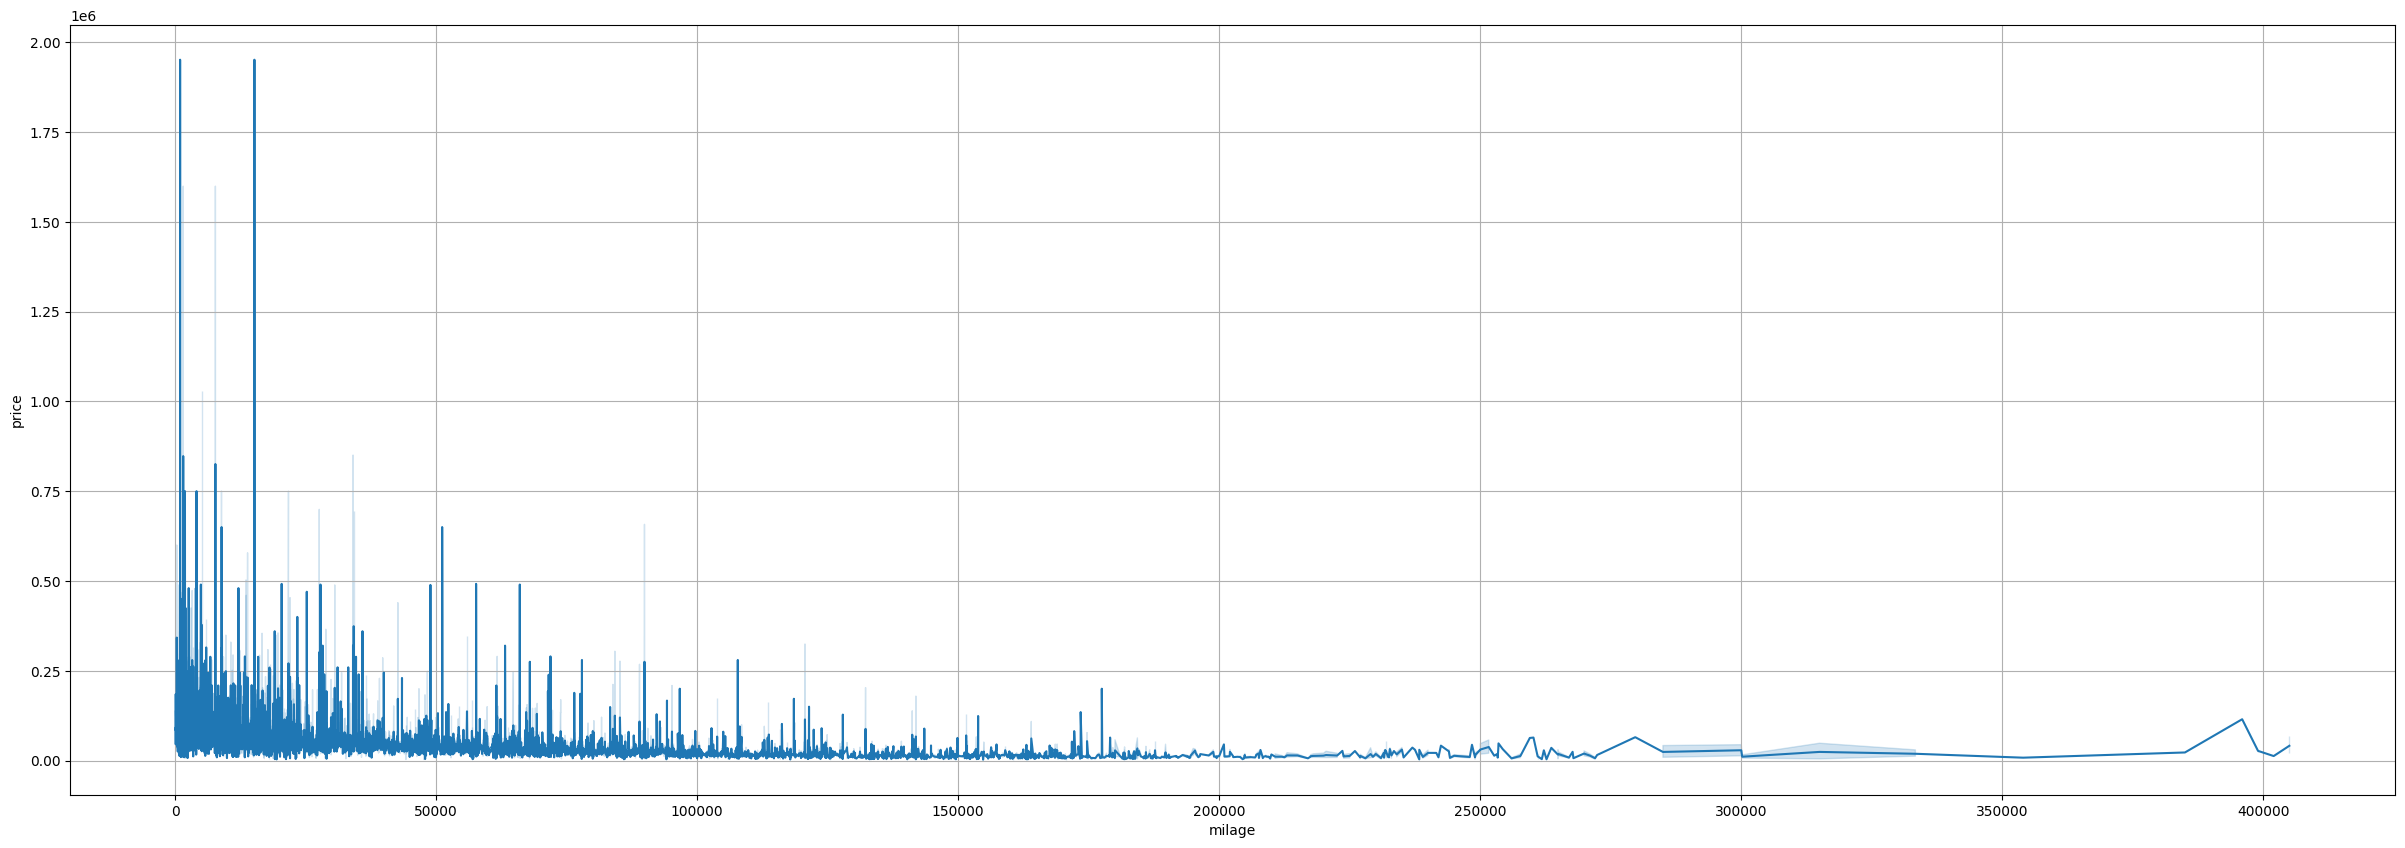

In [23]:
draw_numeric_features(data=raw_df, x='milage', y='price')

In [24]:
def help_change_milage(x):
    milage_str = str(x).split(' ')[0]
    milage_lst = milage_str.split(',')
    if len(milage_lst) >= 2:
        return int(milage_lst[0]) * 1000 + int(milage_lst[1])
    return int(milage_lst[0])
original_df['milage'] = original_df['milage'].apply(lambda x: help_change_milage(x))

In [25]:
def get_milage_group(x):
    if x<=20000:
        return 4
    if x<=70000:
        return 3
    if x<=120000:
        return 2
    if x<=190000:
        return 1
    return 0

In [26]:
for df in [raw_df, test_df, original_df]:
    df['milage_group'] = df['milage'].apply(lambda x: get_milage_group(x))

In [27]:
view_avg_of_each('milage_group','price')

0    13805.392821
1    14252.966050
4    83439.145064
3    46213.138404
2    24330.013339
dtype: float64

In [28]:
numeric_features += ['milage','milage_group']

### Fuel Type

In [29]:
raw_df['fuel_type'].value_counts(dropna=False)

fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
NaN                 5083
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15
Name: count, dtype: int64

In [30]:
for df in [raw_df, test_df, original_df]:
    df['fuel_type'] = df['fuel_type'].apply(lambda x: 'rem' if (x==np.nan or str(x)=='nan') else x)

In [31]:
view_avg_of_each('fuel_type', 'price')

Gasoline          43360.013782
E85 Flex Fuel     26729.755457
rem               60822.612040
Hybrid            55473.451698
Diesel            48769.587358
Plug-In Hybrid    44150.967370
–                 36414.285531
not supported     20692.733333
dtype: float64

In [32]:
categorical_features.append('fuel_type')

### Engine

In [33]:
raw_df['engine'].isna().sum()

0

In [34]:
len(raw_df['engine'].unique())

1117

In [35]:
def split_engine(x, need_find: str):
    result = {'HP':np.nan, 'L':np.nan, 'EngineType': 'rem'}
    x_lst = str(x).split(' ')
    idx_find = {'HP':-1, 'L':-1, 'EngineType':-1}
    for i in range(len(x_lst)):
        e = x_lst[i]
        if e.find('HP')>=0 and idx_find['HP']==-1:
            result['HP'] = e.split('HP')[0]
            idx_find['HP'] = i
        elif e.find('L')>0 and idx_find['L']==-1:
            result['L'] = e.split('L')[0]
            idx_find['L'] = i
        elif e == 'Liter' and idx_find['L']==-1 and i>=1:
            result['L'] = x_lst[i-1]
            idx_find['L'] = i
        elif e in ['Cylinder', 'SOHC', 'DOHC', 'OHV', 'Electric'] and idx_find['EngineType']==-1:
            result['EngineType'] = e
            idx_find['EngineType'] = i
        else:
            continue
    return result[need_find]

In [36]:
noise_engine = raw_df['engine'].value_counts(dropna=False)
noise_engine = noise_engine[noise_engine<min_threshold]
len(noise_engine)

711

In [37]:
for df in [raw_df, test_df, original_df]:
    df['HP'] = df['engine'].apply(lambda x: split_engine(x, 'HP'))
    df['HP'] = df['HP'].astype('float32')
    df['L'] = df['engine'].apply(lambda x: split_engine(x, 'L'))
    df['L'] = df['L'].astype('float32')
    df['EngineType'] = df['engine'].apply(lambda x: split_engine(x, 'EngineType'))
    df['engine'] = df['engine'].apply(lambda x: 'noise' if x in noise_engine else x)

In [38]:
avg_hp_of_engine_type = raw_df.groupby('EngineType')['HP'].mean()
avg_hp_of_engine_type['DOHC']=420
avg_hp_of_engine_type['OHV']=600
avg_hp_of_engine_type['SOHC']=200
avg_hp_of_engine_type

EngineType
Cylinder    338.147766
DOHC        420.000000
Electric    509.035553
OHV         600.000000
SOHC        200.000000
rem         224.112671
Name: HP, dtype: float32

In [39]:
avg_l_of_engine_type = raw_df.groupby('EngineType')['L'].mean()
avg_l_of_engine_type

EngineType
Cylinder    3.821541
DOHC        3.304336
Electric    0.845652
OHV         5.825235
SOHC        3.340857
rem         2.998732
Name: L, dtype: float32

In [40]:
for df in [raw_df, test_df, original_df]:
    df['HP'] = df.apply(lambda x: x['HP'] if x['HP']>=0 else avg_hp_of_engine_type.get(x['EngineType']), axis=1)
    df['L'] = df.apply(lambda x: x['L'] if x['L']>=0 else avg_l_of_engine_type.get(x['EngineType']), axis=1)

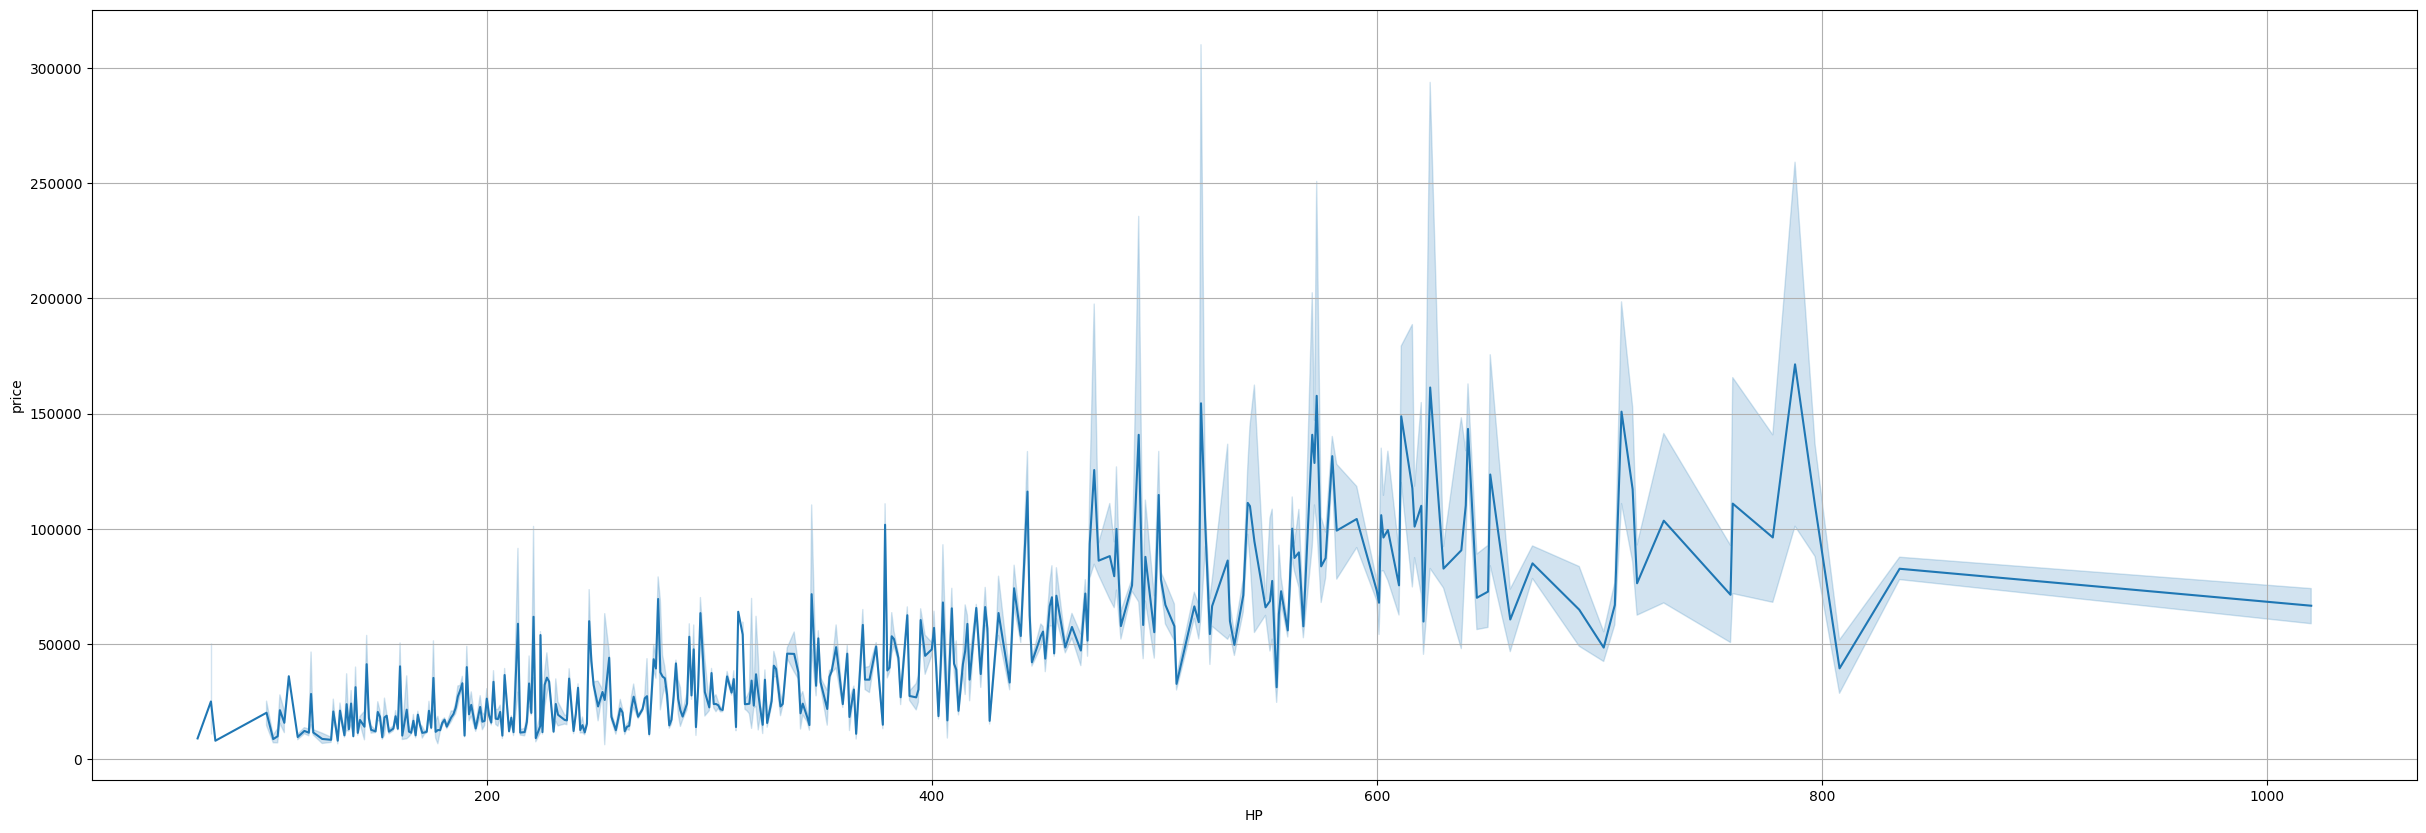

In [41]:
draw_numeric_features(raw_df, 'HP', 'price')

In [42]:
view_avg_of_each('EngineType','price')

Cylinder    38861.091978
DOHC        68014.759650
Electric    60639.006215
OHV         70728.657875
rem         53557.271687
SOHC        54658.378913
dtype: float64

In [43]:
len(raw_df[['HP','L','EngineType']].value_counts()), len(raw_df['engine'].value_counts())

(929, 407)

In [44]:
numeric_features += ['HP','L']
categorical_features += ['engine','EngineType']

### Transmission

In [45]:
len(raw_df['transmission'].unique())

52

In [46]:
noise_transmission = raw_df['transmission'].value_counts(dropna=False)
noise_transmission = noise_transmission[noise_transmission<min_threshold]
len(noise_transmission)

22

In [47]:
for df in [raw_df, test_df, original_df]:
    df['transmission'] = df['transmission'].apply(lambda x: 'noise' if x in noise_transmission else x)

In [48]:
view_avg_of_each('transmission','price')

A/T                                   31711.979140
Transmission w/Dual Shift Mode        50201.815580
7-Speed A/T                           47123.507371
8-Speed A/T                           56442.748656
10-Speed Automatic                    63990.058786
1-Speed A/T                           57869.525415
6-Speed A/T                           25864.659998
10-Speed A/T                          58806.705992
9-Speed A/T                           58859.512675
8-Speed Automatic                     68268.461986
9-Speed Automatic                     64636.535914
5-Speed A/T                           21194.608952
Automatic                             59588.575344
7-Speed Automatic with Auto-Shift    123758.630546
CVT Transmission                      25586.597990
5-Speed M/T                           16330.051889
M/T                                   27914.500424
6-Speed M/T                           33266.568011
6-Speed Automatic                     38884.419436
noise                          

In [49]:
categorical_features += ['transmission']

### Color

In [50]:
for df in [raw_df, test_df, original_df]:
    df['ext_col'] = df['ext_col'].apply(lambda x: str(x).lower())
    df['int_col'] = df['int_col'].apply(lambda x: str(x).lower())

In [51]:
noise_ext_col = raw_df['ext_col'].value_counts(dropna=False)
noise_ext_col = noise_ext_col[noise_ext_col<min_threshold]

noise_int_col = raw_df['int_col'].value_counts(dropna=False)
noise_int_col = noise_int_col[noise_int_col<min_threshold]

len(noise_ext_col), len(noise_int_col)

(257, 119)

In [52]:
for df in [raw_df, test_df, original_df]:
    df['ext_col'] = df['ext_col'].apply(lambda x: 'noise' if x in noise_ext_col else x)
    df['int_col'] = df['int_col'].apply(lambda x: 'noise' if x in noise_int_col else x)

In [53]:
categorical_features += ['ext_col','int_col']

### Accident

In [54]:
raw_df['accident'].value_counts(dropna=False)

accident
None reported                             144514
At least 1 accident or damage reported     41567
NaN                                         2452
Name: count, dtype: int64

In [55]:
for df in [raw_df, test_df, original_df]:
    df['accident'] = df['accident'].apply(lambda x: 1 if x=='At least 1 accident or damage reported' else 0)

In [56]:
view_avg_of_each('accident','price')

0    49122.876550
1    25334.071475
dtype: float64

In [57]:
numeric_features.append('accident')

### Clean title

In [58]:
raw_df['clean_title'].value_counts(dropna=False)

clean_title
Yes    167114
NaN     21419
Name: count, dtype: int64

In [59]:
for df in [raw_df, test_df, original_df]:
    df['clean_title'] = df['clean_title'].apply(lambda x: 1 if x=='Yes' else 0)

In [60]:
view_avg_of_each('clean_title','price')

1    41354.406704
0    63567.566273
dtype: float64

In [61]:
numeric_features.append('clean_title')

In [62]:
len(numeric_features), len(categorical_features)

(9, 9)

### Interactive Features

In [63]:
brand_model_group_price = raw_df.groupby(['brand','model'])['price'].mean()
fuel_engine_transmission_group_price = raw_df.groupby(['fuel_type','EngineType','transmission'])['price'].mean()
fuel_engine_group_price = raw_df.groupby(['fuel_type','EngineType'])['price'].mean()

In [64]:
for df in [raw_df, test_df, original_df]:
    df['mile_per_year'] = df['milage'] / (df['model_year']+1)
    df['HP_per_L'] = df['HP'] / df['L']
    df['brand_model_price'] = df.apply(lambda x: brand_model_group_price.get((x['brand'],
                                                                              x['model'])), 
                                       axis=1)
    df['fuel_engine_transmission_price'] = df.apply(lambda x: fuel_engine_transmission_group_price.get((x['fuel_type'],
                                                                                                        x['EngineType'],
                                                                                                        x['transmission'])), 
                                                    axis=1)
    df['fuel_engine_price'] = df.apply(lambda x: fuel_engine_group_price.get((x['fuel_type'],
                                                                              x['EngineType'])),
                                       axis=1)

In [65]:
avg_brand_model_price = raw_df['brand_model_price'].mean()
avg_fuel_engine_transmission_price = raw_df['fuel_engine_transmission_price'].mean()
avg_fuel_engine_price = raw_df['fuel_engine_price'].mean()
test_df.fillna({'brand_model_price': avg_brand_model_price,
                'fuel_engine_transmission_price': avg_fuel_engine_transmission_price,
                'fuel_engine_price': avg_fuel_engine_price},
               inplace=True)

In [66]:
original_df.fillna({'brand_model_price': avg_brand_model_price,
                'fuel_engine_transmission_price': avg_fuel_engine_transmission_price,
                'fuel_engine_price': avg_fuel_engine_price},
               inplace=True)

In [67]:
numeric_features += ['mile_per_year',
                     'HP_per_L',
                     'brand_model_price',
                     'fuel_engine_transmission_price',
                     'fuel_engine_price']

## Preprocessing

In [68]:
len(original_df)

4009

In [69]:
original_df['id'] = [i for i in range(314223,314223+4009)]
def help_change_price(x):
    milage_str = str(x).split('$')[1]
    milage_lst = milage_str.split(',')
    if len(milage_lst) >= 2:
        return int(milage_lst[0]) * 1000 + int(milage_lst[1])
    return int(milage_lst[0])
original_df['price'] = original_df['price'].apply(lambda x: help_change_price(x))

In [70]:
concat_cols = ['id'] + categorical_features + numeric_features

In [71]:
concat_df = pd.concat([raw_df[concat_cols], test_df[concat_cols], original_df[concat_cols]]).copy()
concat_df.head()

,id,brand,model,short_model,fuel_type,engine,EngineType,transmission,ext_col,int_col,...,milage_group,HP,L,accident,clean_title,mile_per_year,HP_per_L,brand_model_price,fuel_engine_transmission_price,fuel_engine_price
0,0,MINI,Cooper S Base,Cooper,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,Cylinder,A/T,yellow,gray,...,0,172.0,1.6,0,1,11833.333333,107.499998,12778.315972,29308.109531,38600.009988
1,1,Lincoln,noise,LS,Gasoline,noise,Cylinder,A/T,silver,beige,...,1,252.0,3.9,1,1,6228.260870,64.615383,27746.704156,29308.109531,38600.009988
2,2,Chevrolet,noise,Silverado,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,Cylinder,A/T,blue,gray,...,1,320.0,5.3,0,1,5944.826087,60.377356,35853.372897,23435.798489,25241.280210
3,3,Genesis,noise,G90,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Cylinder,Transmission w/Dual Shift Mode,black,black,...,4,420.0,5.0,0,1,2437.500000,84.000000,53186.033730,50007.655618,38600.009988
4,4,Mercedes-Benz,Metris Base,Metris,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,Cylinder,7-Speed A/T,black,beige,...,4,208.0,2.0,0,1,1847.000000,104.000000,64855.673077,47077.069043,38600.009988


In [72]:
encoder = OrdinalEncoder()
encoder.fit(concat_df[categorical_features])

OrdinalEncoder()

In [73]:
for df in [raw_df, test_df, original_df]:
    df[categorical_features] = encoder.transform(df[categorical_features])

In [74]:
all_features = numeric_features + categorical_features
len(all_features)

23

In [75]:
inputs, targets = raw_df[all_features], raw_df['price']

In [76]:
%%time
mutual_info = mutual_info_classif(inputs, targets, random_state=42)
mutual_info = pd.Series(mutual_info)
mutual_info.index = inputs.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] )
mutual_info.style.background_gradient("cool")

CPU times: user 1min 34s, sys: 476 ms, total: 1min 34s
Wall time: 1min 34s


,Numerical_Feature_MI
milage,0.682321
engine,0.579831
assessing_epreciation_percent,0.553326
model_year,0.552323
HP,0.535816
HP_per_L,0.507666
fuel_engine_transmission_price,0.467223
transmission,0.443701
model_year_group,0.415772
milage_group,0.391030


In [77]:
original_features.remove('id')
original_features.remove('price')
original_features

['brand',
 'model',
 'model_year',
 'milage',
 'fuel_type',
 'engine',
 'transmission',
 'ext_col',
 'int_col',
 'accident',
 'clean_title']

I have chosen a list of features that I fill important

In [78]:
importance_features = ['milage','model_year','assessing_epreciation_percent',
                       'HP_per_L','transmission',
                       'engine','brand_model_price',
                       'model','fuel_engine_transmission_price',
                       'clean_title', 'ext_col','int_col',
                       'brand','fuel_type','accident']
len(importance_features)

15

In [79]:
len(all_features)

23

## Training model and tunning hyperparameters

In [80]:
inte_cols = ['brand','model','fuel_type','engine','transmission',
             'ext_col','int_col','short_model','EngineType']
for col in inte_cols:
    raw_df[col] = raw_df[col].astype('int32')
    test_df[col] = test_df[col].astype('int32')
    original_df[col] = original_df[col].astype('int32')

In [81]:
concat_df = pd.concat([raw_df, original_df]).copy()
concat_df = concat_df.reset_index(drop=True)

In [82]:
def cross_validation(reg, cv, inputs, targets, test_inputs=None, need_print=False):
    train_losses = []
    val_losses = []
    if test_inputs is not None:
        test_preds = np.zeros(len(test_inputs))
    else:
        test_preds = np.zeros(len(inputs))
    for fold, (train_idx, val_idx) in enumerate(cv.split(inputs, targets)):
        X_train = inputs.iloc[train_idx].reset_index(drop=True)
        y_train = targets.iloc[train_idx].reset_index(drop=True)
        X_val = inputs.iloc[val_idx].reset_index(drop=True)
        y_val = targets.iloc[val_idx].reset_index(drop=True)

        reg.fit(X_train, y_train)

        train_pred = reg.predict(X_train)
        train_loss = np.sqrt(mean_squared_error(y_train, train_pred))
        train_losses.append(train_loss)
        val_pred = reg.predict(X_val)
        val_loss = np.sqrt(mean_squared_error(y_val, val_pred))
        val_losses.append(val_loss)

        if need_print:
            print(f'Fold {fold}: train_loss = {train_loss:.5f}, val_loss = {val_loss:.5f}')

        if test_inputs is not None:
            test_pred = reg.predict(test_inputs)
            test_preds += test_pred/cv.get_n_splits()

    m_train_loss = np.mean(train_losses)
    s_train_loss = np.std(train_losses)
    m_val_loss = np.mean(val_losses)
    s_val_loss = np.std(val_losses)
    
    msg = f'{m_val_loss:.7f} ± {s_val_loss:.7f}'
    
    if need_print:
        print(f'Train loss: {m_train_loss:.7f} ± {s_train_loss:.7f} | Val loss: {m_val_loss:.7f} ± {s_val_loss:.7f}')
    return test_preds, msg

In [83]:
def test_with_models(models: dict, features: dict, 
                     df: pd.DataFrame, target: str, cv):
    result = dict()
    result['Regressor'] = []
    for feature, _ in features.items():
        result[f'RMSE with {feature} features'] = []
    targets = df[target]
    for name, model in models.items():
        result['Regressor'].append(name)
        for f_name, feature in features.items():
            inputs = df[feature]
            _, msg = cross_validation(model, cv, 
                                      inputs, targets, 
                                      test_inputs=None, 
                                      need_print=False)
            result[f'RMSE with {f_name} features'].append(msg)
    
    return pd.DataFrame(result)

In [84]:
regressors = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'RandomForestRegressor': RandomForestRegressor(n_jobs=-1),
    'XGBRegressor': XGBRegressor(n_jobs=-1),
    'LGBMRegressor': LGBMRegressor(n_jobs=-1, verbose=0),
    'CatBoostRegressor': CatBoostRegressor(logging_level='Silent')
}
features = {
    'all': all_features,
    'original': original_features,
    'importance': importance_features
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [85]:
%%time
test_with_models(regressors, features, raw_df, 'price', cv)

CPU times: user 1h 12min 30s, sys: 55.5 s, total: 1h 13min 26s
Wall time: 20min 21s


,Regressor,RMSE with all features,RMSE with original features,RMSE with importance features
0,LinearRegression,73348.8615551 ± 184.2839383,74957.7943141 ± 175.2538847,73491.2788509 ± 178.8616177
1,Ridge,73348.8613378 ± 184.2832663,74957.7942261 ± 175.2539880,73491.2787767 ± 178.8615462
2,DecisionTreeRegressor,107567.9342036 ± 2266.8461680,113211.5551814 ± 2632.5695352,112418.7500052 ± 5532.2336725
3,RandomForestRegressor,77878.6242257 ± 462.9043080,78277.6592819 ± 454.1309325,78203.6547264 ± 556.5355863
4,XGBRegressor,75878.8835495 ± 485.7405092,75130.2879158 ± 216.7417826,75472.1064604 ± 516.9135262
5,LGBMRegressor,73039.7907370 ± 234.1091058,73059.5678955 ± 142.6199133,72974.2765527 ± 224.4688789
6,CatBoostRegressor,73892.0866937 ± 328.7558221,73815.2545957 ± 399.1628689,73980.5915088 ± 324.7950145


So we choose 3 model to view with `concat_df`, are
1. Linear Regression
2. LGBM Regressor
3. CatBoostRegressor

In [86]:
regressors = {
    'LinearRegression': LinearRegression(),
    'LGBMRegressor': LGBMRegressor(n_jobs=-1, verbose=0),
    'CatBoostRegressor': CatBoostRegressor(logging_level='Silent')
}
features = {
    'all': all_features,
    'original': original_features,
    'importance': importance_features
}

In [87]:
%%time
result_df = test_with_models(regressors, features, concat_df, 'price', cv)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklea

CPU times: user 17min 7s, sys: 40.8 s, total: 17min 47s
Wall time: 5min 30s


In [88]:
result_df

,Regressor,RMSE with all features,RMSE with original features,RMSE with importance features
0,LinearRegression,72763.9163446 ± 365.3429900,74439.4463170 ± 329.8490837,72910.5912975 ± 367.7272879
1,LGBMRegressor,72422.6855465 ± 385.3643520,72511.7220374 ± 358.6435397,72450.5065706 ± 397.7591638
2,CatBoostRegressor,73053.9639553 ± 294.9529150,73038.6166105 ± 175.5798309,73307.9874660 ± 445.2878678


From this result, we can see that original model make a huge decrese in RMSE, and we can choose `importance_features` for LinearRegression, `all_features` and `original_features` for LGBM and CatBoost (with std smaller).

In [89]:
# Save the LB score
lb_dict = dict()

### Linear Regression

In [90]:
inputs, targets = concat_df[importance_features], concat_df['price']
test_inputs = test_df[importance_features]

In [91]:
%%time
reg = LinearRegression()
test_preds, _ = cross_validation(reg, cv, inputs, targets, test_inputs, need_print=True)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 0: train_loss = 72792.35156, val_loss = 73345.25138
Fold 1: train_loss = 72850.08322, val_loss = 73111.55824
Fold 2: train_loss = 73010.75455, val_loss = 72468.71334
Fold 3: train_loss = 73009.42694, val_loss = 72472.56122
Fold 4: train_loss = 72839.92698, val_loss = 73154.87231
Train loss: 72900.5086500 ± 91.5731094 | Val loss: 72910.5912975 ± 367.7272879
CPU times: user 2.69 s, sys: 681 ms, total: 3.38 s
Wall time: 1.2 s


In [92]:
sub_df['price'] = test_preds
sub_df.to_csv('/kaggle/working/sub_linear.csv', index=None)
sub_df.head()
#LB: 73538.59470
lb_dict['linear'] = 73538.59470

### LGBM Regressor

In [93]:
param_dis = {
    'num_leaves': np.arange(35,300,7),
    'n_jobs': [-1],
    'reg_lambda': loguniform(1e-5,4),
    'reg_alpha': loguniform(1e-5,4),
    'n_estimators': np.arange(90,341,40),
    'learning_rate': loguniform(0.001,0.2),
    'max_depth': np.arange(25,55,3),
    'min_split_gain': loguniform(1e-8,0.1),
    'min_child_weight': loguniform(1e-4,0.1),
    'min_child_samples': np.arange(14,30,4),
    'subsample': loguniform(0.25,1),
    'colsample_bytree': loguniform(0.25,1),
    'random_state': [42],
    'verbose': [0]
}

In [94]:
# Search for all features
'''
search = RandomizedSearchCV(LGBMRegressor(),
                            param_dis,
                            n_iter=120,
                            scoring='neg_root_mean_squared_error', cv=4,
                            refit=True, verbose=3)
inputs, targets = concat_df[all_features], concat_df['price']
test_inputs = test_df[all_features]
search.fit(inputs, targets)
'''

"\nsearch = RandomizedSearchCV(LGBMRegressor(),\n                            param_dis,\n                            n_iter=120,\n                            scoring='neg_root_mean_squared_error', cv=4,\n                            refit=True, verbose=3)\ninputs, targets = concat_df[all_features], concat_df['price']\ntest_inputs = test_df[all_features]\nsearch.fit(inputs, targets)\n"

In [95]:
all_f_best_params = {
    'colsample_bytree': 0.2758204682094911,
    'learning_rate': 0.01732638635468214,
    'max_depth': 25,
    'min_child_samples': 22,
    'min_child_weight': 0.005920952507638368,
    'min_split_gain': 0.00017795678355682018,
    'n_estimators': 330,
    'n_jobs': -1,
    'num_leaves': 70,
    'random_state': 42,
    'reg_alpha': 0.0008202625309476396,
    'reg_lambda': 0.008483893356895155,
    'subsample': 0.8197692565344892,
    'verbose': 0
}
reg = LGBMRegressor(**all_f_best_params)

In [96]:
%%time
inputs, targets = concat_df[all_features], concat_df['price']
test_inputs = test_df[all_features]
test_preds, _ = cross_validation(reg, cv, inputs, targets, test_inputs, need_print=True)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 0: train_loss = 68194.32974, val_loss = 72540.13409
Fold 1: train_loss = 68058.15904, val_loss = 72275.42802
Fold 2: train_loss = 68182.78698, val_loss = 71797.15054
Fold 3: train_loss = 68497.72318, val_loss = 71496.54412
Fold 4: train_loss = 68073.53183, val_loss = 72257.68876
Train loss: 68201.3061561 ± 158.1594491 | Val loss: 72073.3891058 ± 374.6184298
CPU times: user 1min 18s, sys: 13 ms, total: 1min 18s
Wall time: 1min 18s


In [97]:
sub_df['price'] = test_preds
sub_df.to_csv('/kaggle/working/sub_lgbm_all.csv', index=None)
sub_df.head()
#LB: 72440.64497
lb_dict['LGBM with all features'] = 72440.64497 

In [98]:
# Search for original features
param_dis = {
    'num_leaves': np.arange(35,300,7),
    'n_jobs': [-1],
    'reg_lambda': loguniform(1e-5,4),
    'reg_alpha': loguniform(1e-5,4),
    'n_estimators': np.arange(90,341,40),
    'learning_rate': loguniform(0.001,0.2),
    'max_depth': np.arange(35,60,3),
    'min_split_gain': loguniform(1e-8,0.1),
    'min_child_weight': loguniform(1e-4,0.1),
    'min_child_samples': np.arange(14,30,4),
    'subsample': loguniform(0.25,1),
    'colsample_bytree': loguniform(0.25,1),
    'random_state': [42],
    'verbose': [0]
}
'''
search = RandomizedSearchCV(LGBMRegressor(),
                            param_dis,
                            n_iter=120,
                            scoring='neg_root_mean_squared_error', cv=4,
                            refit=True, verbose=3)
inputs, targets = concat_df[original_features], concat_df['price']
test_inputs = test_df[original_features]
search.fit(inputs, targets)
'''

"\nsearch = RandomizedSearchCV(LGBMRegressor(),\n                            param_dis,\n                            n_iter=120,\n                            scoring='neg_root_mean_squared_error', cv=4,\n                            refit=True, verbose=3)\ninputs, targets = concat_df[original_features], concat_df['price']\ntest_inputs = test_df[original_features]\nsearch.fit(inputs, targets)\n"

In [99]:
ori_f_best_params = {
    'colsample_bytree': 0.4780013232664833,
    'learning_rate': 0.007510835510779154,
    'max_depth': 53,
    'min_child_samples': 22,
    'min_child_weight': 0.0068460232273130335,
    'min_split_gain': 2.8810783623795097e-08,
    'n_estimators': 330,
    'n_jobs': -1,
    'num_leaves': 231,
    'random_state': 42,
    'reg_alpha': 0.016505184112964685,
    'reg_lambda': 0.00013891421826824215,
    'subsample': 0.49955117962103773,
    'verbose': 0
}
reg = LGBMRegressor(**ori_f_best_params)

In [100]:
%%time
inputs, targets = concat_df[original_features], concat_df['price']
test_inputs = test_df[original_features]
test_preds, _ = cross_validation(reg, cv, inputs, targets, test_inputs, need_print=True)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 0: train_loss = 68786.13155, val_loss = 72820.40726
Fold 1: train_loss = 68795.82442, val_loss = 72521.71828
Fold 2: train_loss = 69000.18616, val_loss = 71909.13552
Fold 3: train_loss = 69037.09209, val_loss = 71796.25270
Fold 4: train_loss = 68730.93654, val_loss = 72543.11200
Train loss: 68870.0341521 ± 123.8892880 | Val loss: 72318.1251526 ± 395.9747293
CPU times: user 2min 1s, sys: 34.3 ms, total: 2min 1s
Wall time: 2min 1s


In [101]:
sub_df['price'] = test_preds
sub_df.to_csv('/kaggle/working/sub_lgbm_ori.csv', index=None)
sub_df.head()
## LB: 72475.26745
lb_dict['LGBM with original features'] = 72475.64497 

In [102]:
%%time
reg = LGBMRegressor(**all_f_best_params)
# Test with original features and best params of all features
test_preds, _ = cross_validation(reg, cv, inputs, targets, test_inputs, need_print=True)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 0: train_loss = 70352.27614, val_loss = 72748.53117
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 1: train_loss = 70334.34699, val_loss = 72410.40752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 2: train_loss = 70607.61737, val_loss = 71732.17209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 3: train_loss = 70676.18333, val_loss = 71658.72620
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 4: train_loss = 7

In [103]:
sub_df['price'] = test_preds
sub_df.to_csv('/kaggle/working/sub_lgbm_all_ori.csv', index=None)
sub_df.head()
## LB: 72362.53542
lb_dict['LGBM with original features and params opt by all features'] = 72362.53542 

### CatBoost

In [104]:
# Search for all features
param_dis = {
    'eval_metric': ['RMSE'],
    'iterations': np.arange(750,1800,250),
    'learning_rate': loguniform(0.005,0.1),
    'random_seed': [42],
    'l2_leaf_reg': loguniform(0.8,50),
    'bagging_temperature': loguniform(1e-4,1),
    'random_strength': np.arange(1,10),
    'depth': np.arange(6,10),
    'min_data_in_leaf': np.arange(1,4),
    'border_count': np.arange(64,256,50),
    'logging_level': ['Silent']
}
'''
search = RandomizedSearchCV(CatBoostRegressor(),
                            param_dis,
                            n_iter=60,
                            scoring='neg_root_mean_squared_error', cv=4,
                            refit=True, verbose=3)
inputs, targets = concat_df[all_features], concat_df['price']
test_inputs = test_df[all_features]
# Fit in 2h3min
%%time
search.fit(inputs, targets)
'''

"\nsearch = RandomizedSearchCV(CatBoostRegressor(),\n                            param_dis,\n                            n_iter=60,\n                            scoring='neg_root_mean_squared_error', cv=4,\n                            refit=True, verbose=3)\ninputs, targets = concat_df[all_features], concat_df['price']\ntest_inputs = test_df[all_features]\n# Fit in 2h3min\n%%time\nsearch.fit(inputs, targets)\n"

In [105]:
all_f_best_params = {
    'bagging_temperature': 0.03511697617804005,
    'border_count': 114,
    'depth': 9,
    'eval_metric': 'RMSE',
    'iterations': 1500,
    'l2_leaf_reg': 10.454859619147957,
    'learning_rate': 0.005887205040643729,
    'logging_level': 'Silent',
    'min_data_in_leaf': 1,
    'random_seed': 42,
    'random_strength': 7
}
reg = CatBoostRegressor(**all_f_best_params)

In [106]:
%%time
inputs, targets = concat_df[all_features], concat_df['price']
test_inputs = test_df[all_features]
# Test with all features and best params of all features
test_preds, _ = cross_validation(reg, cv, inputs, targets, test_inputs, need_print=True)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 0: train_loss = 70634.33020, val_loss = 72487.11044
Fold 1: train_loss = 70664.10933, val_loss = 72150.97340
Fold 2: train_loss = 70778.26171, val_loss = 71585.89576
Fold 3: train_loss = 70948.35067, val_loss = 71510.66739
Fold 4: train_loss = 70620.44457, val_loss = 72271.40318
Train loss: 70729.0992958 ± 122.8811118 | Val loss: 72001.2100333 ± 385.9146640
CPU times: user 14min 13s, sys: 31.2 s, total: 14min 44s
Wall time: 4min 5s


In [107]:
sub_df['price'] = test_preds
sub_df.to_csv('/kaggle/working/sub_cat_all.csv', index=None)
sub_df.head()
## LB: 72511.30022
lb_dict['CatBoost with all features'] = 72511.53542 

In [108]:
%%time
inputs, targets = concat_df[original_features], concat_df['price']
test_inputs = test_df[original_features]
# Test with original features and best params for all features
test_preds, _ = cross_validation(reg, cv, inputs, targets, test_inputs, need_print=True)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 0: train_loss = 71688.27553, val_loss = 73004.77163
Fold 1: train_loss = 71726.83442, val_loss = 72797.47278
Fold 2: train_loss = 71945.21291, val_loss = 72104.54419
Fold 3: train_loss = 71966.38432, val_loss = 72141.38430
Fold 4: train_loss = 71669.76323, val_loss = 72976.11195
Train loss: 71799.2940831 ± 129.2789350 | Val loss: 72604.8569723 ± 399.9956587
CPU times: user 9min 48s, sys: 30.7 s, total: 10min 19s
Wall time: 2min 54s


In [109]:
sub_df['price'] = test_preds
sub_df.to_csv('/kaggle/working/sub_cat_all_ori.csv', index=None)
sub_df.head()
## LB: 72947.82246
lb_dict['CatBoost with original features and params opt by all features'] = 72947.82246 

### View LB Score after submissions

In [110]:
pd.Series(lb_dict)

linear                                                            73538.59470
LGBM with all features                                            72440.64497
LGBM with original features                                       72475.64497
LGBM with original features and params opt by all features        72362.53542
CatBoost with all features                                        72511.53542
CatBoost with original features and params opt by all features    72947.82246
dtype: float64

LGBM with original features and params opt by all features is the highest perfomance.

In [111]:
sub_df = pd.read_csv('/kaggle/working/sub_lgbm_all_ori.csv')
sub_df.head()

,id,price
0,188533,18389.885693
1,188534,74027.682240
2,188535,52662.726415
3,188536,30896.773248
4,188537,30622.704877


In [112]:
sub_df.to_csv('/kaggle/working/submission.csv', index=None)
sub_df.head()

,id,price
0,188533,18389.885693
1,188534,74027.682240
2,188535,52662.726415
3,188536,30896.773248
4,188537,30622.704877
